# Homework Starter — Stage 08 EDA

Fill in the marked TODOs. This notebook generates synthetic data so you can focus on the EDA flow. Replace with your dataset when ready.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)
import pathlib

n = 200
df = pd.DataFrame({
    'date': pd.date_range('2025-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(18, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.002 + df['transactions']*20 + np.random.normal(0, 30, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+15

RAW = pathlib.Path("../data/raw/sample_data.csv")
RAW.parent.mkdir(parents=True, exist_ok=True)  # make sure folder exists
df.to_csv(RAW, index=False)

print(f"✅ Sample data saved to: {RAW}")
df.head()

✅ Sample data saved to: ../data/raw/sample_data.csv


,date,region,age,income,transactions,spend
0,2025-02-01,West,41.2,51712.11,0,109.42
1,2025-02-02,North,40.0,NaN,4,189.84
2,2025-02-03,South,42.7,29900.82,2,39.73
3,2025-02-04,South,43.0,34212.69,5,125.46
4,2025-02-05,South,45.7,67315.90,5,257.72


## 1) First look

In [2]:
import pandas as pd

RAW = "../data/raw/sample_data.csv"
df = pd.read_csv(RAW)

df.head()
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          200 non-null    object 
 1   region        200 non-null    object 
 2   age           200 non-null    float64
 3   income        195 non-null    float64
 4   transactions  200 non-null    int64  
 5   spend         197 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 9.5+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

## 2) Numeric profile

In [3]:

desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,200.0,39.622500,8.157701,19.90,33.875,39.50,44.925,61.10,0.065060,-0.095237
income,195.0,42754.485231,13571.723577,17060.87,33397.095,40684.45,50134.825,87052.40,0.877607,0.697204
transactions,200.0,3.175000,2.639928,0.00,2.000,3.00,4.000,23.00,4.309816,29.673855
spend,197.0,150.768528,53.183469,13.75,113.900,148.97,183.770,326.71,0.385156,0.323717


## 3) Distributions (TODO: add at least 3)

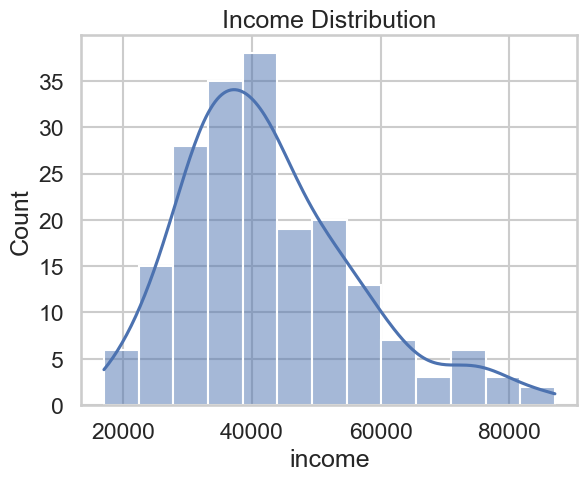

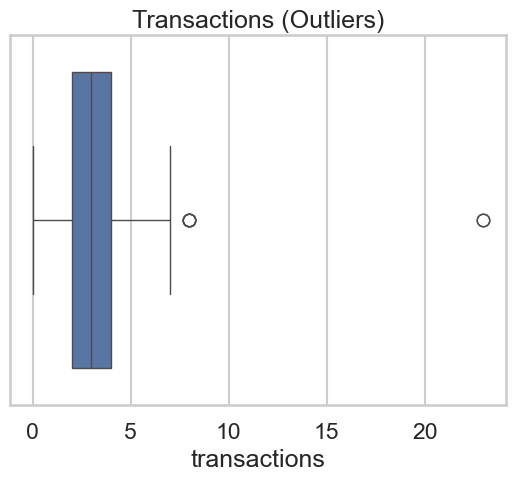

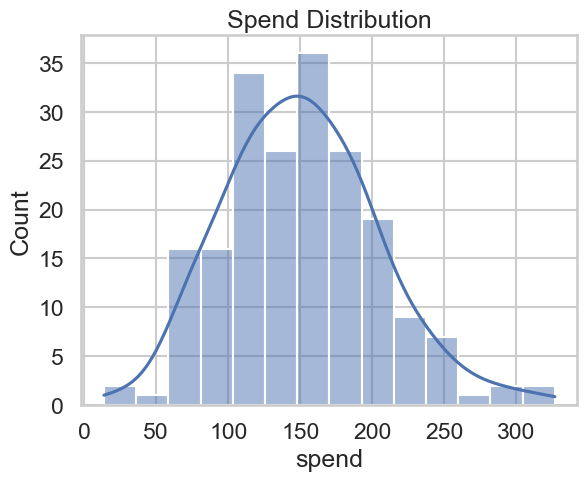

In [4]:

# Income distribution
sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

# Transactions boxplot
sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

# Spend distribution
sns.histplot(df['spend'], kde=True)
plt.title('Spend Distribution')
plt.show()



## 4) Relationships (TODO: add at least 2)

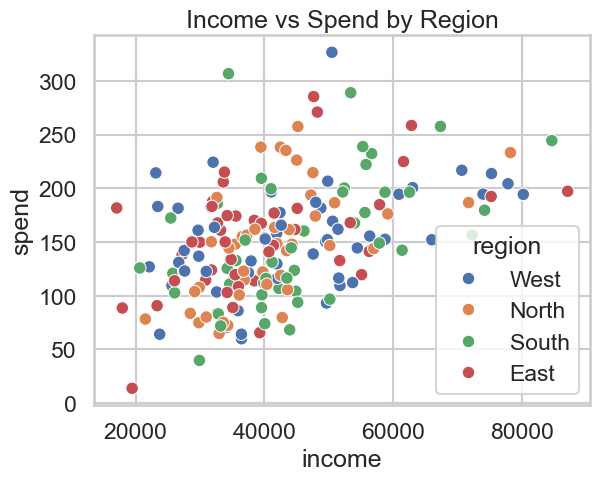

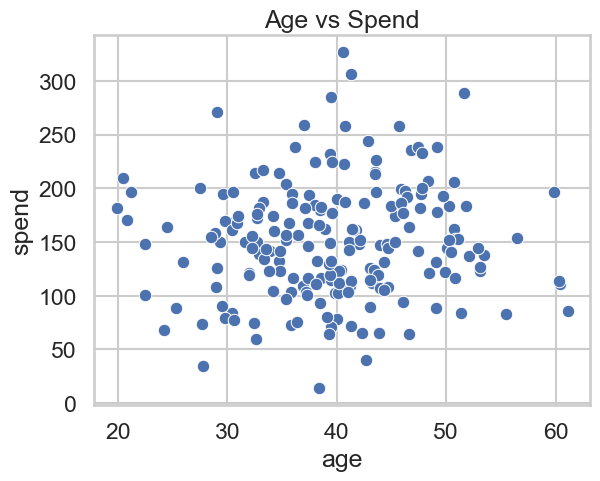

In [5]:


sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend by Region')
plt.show()

sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()


## 5) (Optional) Correlation matrix

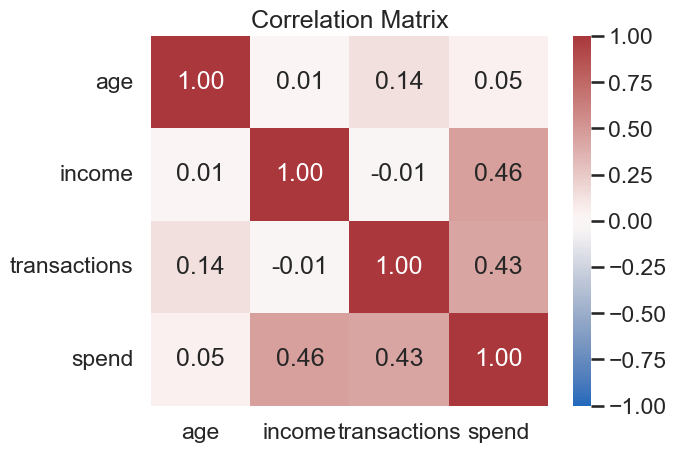

,age,income,transactions,spend
age,1.000000,0.012707,0.139120,0.054418
income,0.012707,1.000000,-0.010782,0.456188
transactions,0.139120,-0.010782,1.000000,0.429820
spend,0.054418,0.456188,0.429820,1.000000


In [6]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

corr

## 6) Insights & Assumptions

### Top 3 Insights
1. **Income distribution is highly right-skewed with several extreme outliers.**  
   - *So what:* This indicates that high-income individuals could dominate the variance in the dataset. Log-transforming income or capping outliers may improve model stability.

2. **Transactions show injected anomalies (two values far above the rest).**  
   - *So what:* If these are true "super users," removing them would discard important behavior patterns. Instead, we may keep them but engineer a new binary flag to capture this effect.

3. **Spend is positively correlated with both income and transactions, but the correlation with transactions is stronger.**  
   - *So what:* This suggests activity level (transaction frequency) drives spend more directly than income. This insight will influence which predictors we prioritize for modeling.

---

### Assumptions & Risks
- Assumption: Missingness in `income` and `spend` is random.  
  - *Risk:* If missingness is systematic (e.g., low-income individuals not reporting), imputation may bias results.  
- Assumption: The synthetic dataset broadly mimics real-world patterns.  
  - *Risk:* If actual business data differs significantly (e.g., seasonal effects), the EDA insights may not generalize.  
- Assumption: Outliers are meaningful signals rather than data entry errors.  
  - *Risk:* Treating erroneous data as valid could distort downstream analysis.

---

### Next Steps Before Modeling
- Impute missing values more carefully (e.g., median by region, or regression-based imputation).  
- Apply log transformation or winsorization to handle skewed `income`.  
- Engineer features:  
  - `is_outlier_transaction` flag for extreme transaction counts.  
  - Interaction terms like `income_per_transaction`.  
- Validate findings once the real dataset is available (check seasonality, regional effects, etc.).


In [9]:
# Example: save processed dataset
PROCESSED = "../data/processed/stage08_clean.csv"

# Simple cleaning demo (drop rows with missing values)
df_clean = df.dropna()

df_clean.to_csv(PROCESSED, index=False)
print(f"Processed dataset saved to {PROCESSED}")


Processed dataset saved to ../data/processed/stage08_clean.csv
